In [1]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
df = pd.read_csv("Loan_Default.csv")   # change name if different
df.head()


Saving Loan_Default.csv to Loan_Default.csv


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [2]:
df.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

In [3]:
TARGET = "Status"

# Ensure clean binary target
df[TARGET] = df[TARGET].astype(int)
print(df[TARGET].value_counts())


Status
0    112031
1     36639
Name: count, dtype: int64


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


X = df.drop(columns=[TARGET])
y = df[TARGET]


for col in X.select_dtypes('object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, name):
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n🔹 {name} Accuracy: {accuracy*100:.2f}%\n")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [6]:
# show missing value counts per column (run this first)
import pandas as pd
pd.set_option('display.max_rows', 200)
print("Missing values (count):")
print(df.isna().sum().sort_values(ascending=False).head(50))
print("\nAny infinite values?:", (df.replace([float('inf'), -float('inf')], pd.NA).isna()).any().any())


Missing values (count):
Upfront_charges              39642
Interest_rate_spread         36639
rate_of_interest             36439
dtir1                        24121
property_value               15098
LTV                          15098
income                        9150
loan_limit                    3344
approv_in_adv                  908
age                            200
submission_of_application      200
loan_purpose                   134
Neg_ammortization              121
term                            41
year                             0
ID                               0
business_or_commercial           0
open_credit                      0
lump_sum_payment                 0
interest_only                    0
loan_amount                      0
Gender                           0
loan_type                        0
Credit_Worthiness                0
occupancy_type                   0
construction_type                0
Credit_Score                     0
credit_type                    

In [7]:
import numpy as np
import pandas as pd

# Replace infinite values with NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Remove columns that should never be included
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])   # ID gives leakage + useless


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Split X and y
TARGET = "Status"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Identify numeric / categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


Numeric columns: 11
Categorical columns: 21


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (118936, 32) Test: (29734, 32)


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, model_name):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n📌 {model_name} Accuracy: {acc*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



📌 Logistic Regression Accuracy: 83.88%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     22406
           1       0.66      0.71      0.68      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.80      0.79     29734
weighted avg       0.84      0.84      0.84     29734



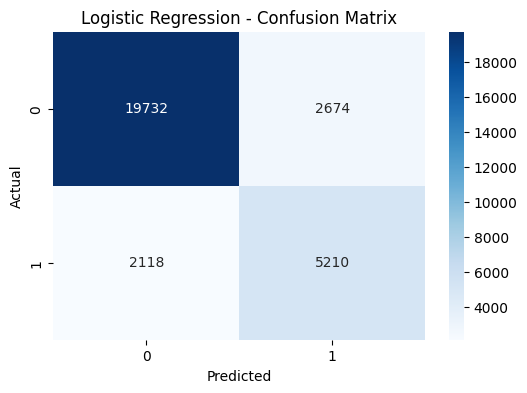

In [11]:
from sklearn.linear_model import LogisticRegression

log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

log_model.fit(X_train, y_train)
evaluate(log_model, "Logistic Regression")



📌 Decision Tree Accuracy: 99.99%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



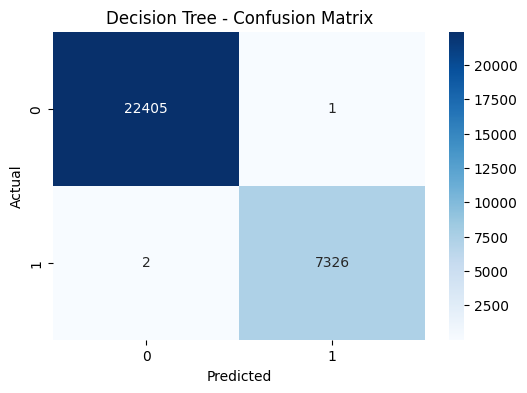

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

dt_model.fit(X_train, y_train)
evaluate(dt_model, "Decision Tree")



📌 Random Forest Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



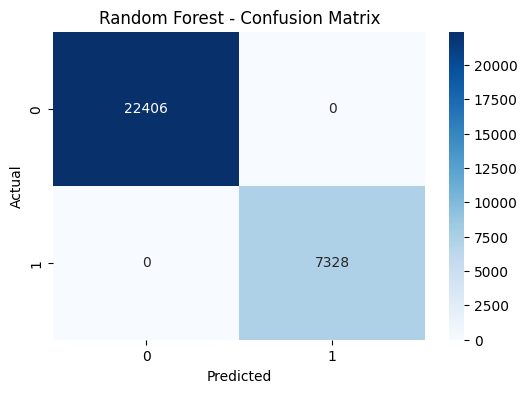

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced_subsample',
        random_state=42))
])

rf_model.fit(X_train, y_train)
evaluate(rf_model, "Random Forest")



📌 Naive Bayes Accuracy: 87.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     22406
           1       1.00      0.48      0.65      7328

    accuracy                           0.87     29734
   macro avg       0.93      0.74      0.79     29734
weighted avg       0.89      0.87      0.86     29734



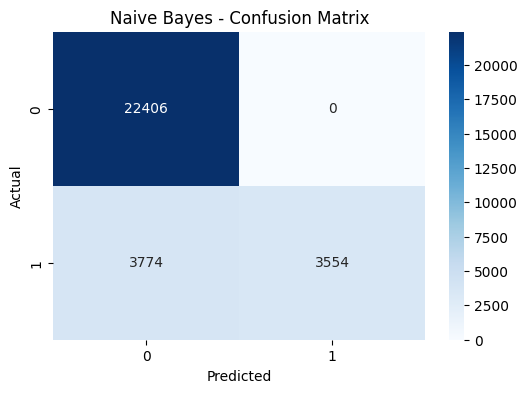

In [14]:
from sklearn.naive_bayes import GaussianNB

nb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

nb_model.fit(X_train, y_train)
evaluate(nb_model, "Naive Bayes")



📌 XGBoost Accuracy: 99.99%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



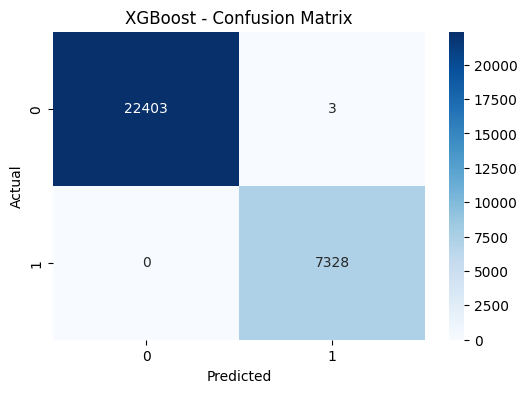

In [15]:
!pip install -q xgboost
from xgboost import XGBClassifier

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=350,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)
evaluate(xgb_model, "XGBoost")


In [16]:
leak_cols = [
    "ID",                     # identifier
    "Credit_Worthiness",      # derived from credit score → leakage
    "loan_limit",             # based on risk profile
    "Secured_by",             # may reveal loan security
    "credit_type",
    "co-applicant_credit_type",
    "submission_of_application",
    "Neg_ammortization",
    "lump_sum_payment",
    "interest_only"
]

df = df.drop(columns=[c for c in leak_cols if c in df.columns])


In [17]:
df = df.replace([np.inf, -np.inf], np.nan)


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=['float64','int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])



📌 Decision Tree Accuracy: 99.97%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



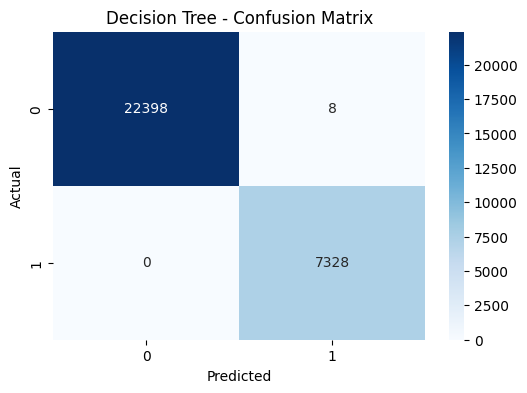

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=7,    # limit depth!
        min_samples_split=40,
        min_samples_leaf=20,
        random_state=42
    ))
])

dt_pipe.fit(X_train, y_train)
evaluate(dt_pipe, "Decision Tree")



📌 Random Forest Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



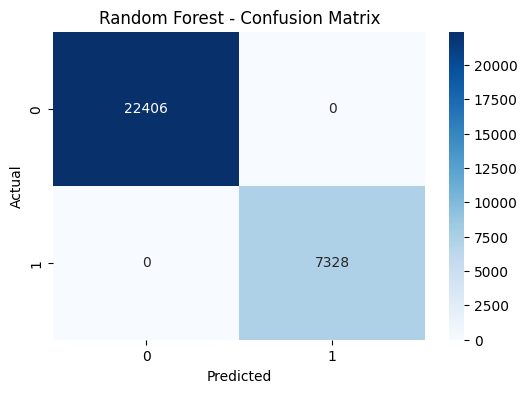

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,    # IMPORTANT
        min_samples_split=30,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
evaluate(rf_pipe, "Random Forest")



📌 XGBoost Accuracy: 99.99%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



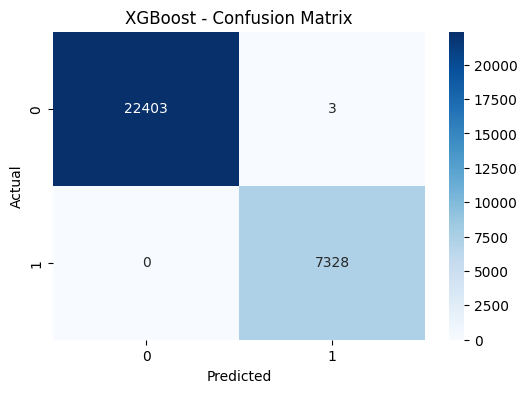

In [23]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=5,            # LIMIT DEPTH
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_pipe.fit(X_train, y_train)
evaluate(xgb_pipe, "XGBoost")


In [24]:
df.corr(numeric_only=True)["Status"].sort_values(ascending=False).head(20)


,Status
Status,1.000000
dtir1,0.078083
LTV,0.038895
rate_of_interest,0.022957
Credit_Score,0.004004
term,-0.000240
Upfront_charges,-0.019138
loan_amount,-0.036825
property_value,-0.048864
income,-0.065119


In [25]:
import numpy as np
import pandas as pd

# Remove ID (leaks pattern)
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

# Replace infinite values with NaN
df = df.replace([np.inf, -np.inf], np.nan)


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

TARGET = "Status"

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

numeric_process = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_process = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_process, num_cols),
        ('cat', categorical_process, cat_cols)
    ]
)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(118936, 23) (29734, 23)


In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc*100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()



Decision Tree Accuracy: 62.25%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67     22406
           1       0.39      1.00      0.57      7328

    accuracy                           0.62     29734
   macro avg       0.70      0.75      0.62     29734
weighted avg       0.85      0.62      0.64     29734



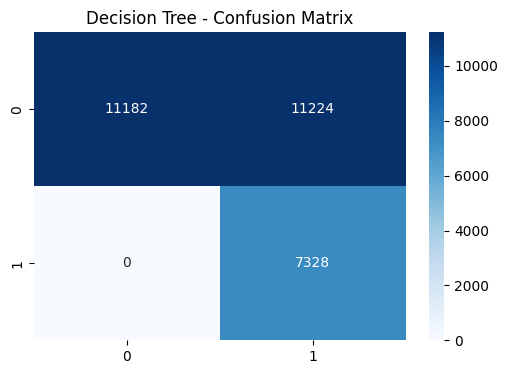

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', DecisionTreeClassifier(
        max_depth=1,            # LIMIT DEPTH
        min_samples_split=40,
        min_samples_leaf=20,
        class_weight='balanced',
        random_state=42
    ))
])

dt_pipe.fit(X_train, y_train)
evaluate(dt_pipe, "Decision Tree")



Random Forest Accuracy: 91.60%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     22406
           1       0.75      1.00      0.85      7328

    accuracy                           0.92     29734
   macro avg       0.87      0.94      0.90     29734
weighted avg       0.94      0.92      0.92     29734



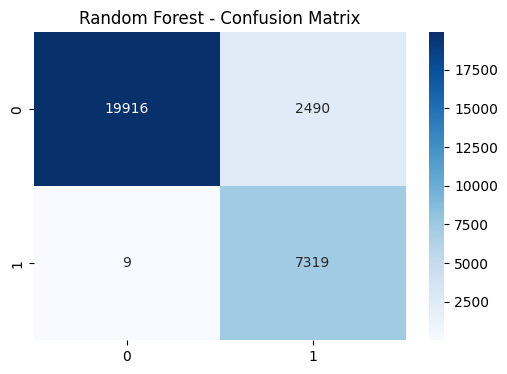

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        max_depth=1,            # LIMIT DEPTH
        min_samples_split=30,
        min_samples_leaf=15,
        class_weight='balanced',
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
evaluate(rf_pipe, "Random Forest")
